In [32]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


In [33]:
# setting up training data
train_data = datasets.FashionMNIST(
    root="data", # where data is being downloaded
    train=True, # get training split
    download=True,
    # images need to be tensors to work with a model
    transform=ToTensor(),
    # don't transform labels
    target_transform=None
)

# setting up testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get testing split
    download=True,
    transform=ToTensor(),
    target_transform=None
)



In [34]:
class_names = train_data.classes
test_classes = test_data.classes

In [35]:
# image, label = train_data[0]
# # plt expects height and width, no color channel
# plt.imshow(image.squeeze())
# plt.title(train_classes[label])

In [36]:
# plt.imshow(image.squeeze(), cmap="gray")
# plt.title(train_classes[label])
# plt.axis(False)

In [37]:
# # just getting an idea of what the data looks like
# fig = plt.figure(figsize=(9, 9))
# rows, cols = 4,4
# for i in range(1, rows * cols+1):
#   random_index = torch.randint(0, len(train_data), size=[1]).item()
#   image, label = train_data[random_index]
#   fig.add_subplot(rows, cols, i)
#   plt.imshow(image.squeeze(), cmap="gray")
#   plt.title(train_classes[label])


In [38]:
# preparing a dataloader
# dataset -> dataloader(turns data into a python iterable )
from torch.utils.data import DataLoader
BATCH_SIZE = 32
# shuffle training data so model doesn't learn img order
dataLoader_Train = DataLoader(train_data, BATCH_SIZE, True)
# shuffle doesn't matter for testing
dataLoader_Test = DataLoader(test_data, BATCH_SIZE, False)

In [39]:
# # interacting with a dataloader
# train_features_batch, train_labels_batch = next(iter(dataLoader_Train))
# plt.imshow(train_features_batch[0].squeeze(), cmap="gray")
# plt.axis(False)
# plt.title(train_classes[0])


In [40]:
class FashionMNISTModelV0(nn.Module):
  def __init__(self, input_shape:int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        # reduce dims of input
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape))
  def forward(self, input):
    return self.layer_stack(input)


In [41]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(
    # refers to shape of input data
    input_shape=28*28,
    hidden_units=10,
    output_shape=len(class_names)
).to("cpu")

In [42]:
def calculateAccuracy(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  return (correct / len(y_pred)) * 100

In [43]:
# setting up a loss, optimizer and evaluation metrics

# we're using multi-class data, so loss fn is CrossEntropy
# optimizer is still SGD
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)

In [44]:
# fn to track model speed
from timeit import default_timer as timer
def print_training_time(startTime:float,
                        endTime:float,
                        device:torch.device = None):
  runTime = endTime - startTime
  print(f"Training time for {device}:{runTime:.3f} seconds ")
  return runTime


In [45]:
# training/testing model
# for now, I'm writing both loops out to practice, but will functionize
torch.manual_seed(42)
# start timer on run
cpuStartTime = timer()
# lower epochs = faster training time
epochs = 3
for epoch in range((epochs)):
  print(f"Epoch # {epoch}")
  train_loss = 0
  # loop through training batches
  for batch, (train_image, label) in enumerate(dataLoader_Train):
    model_0.train()
    # create training predictions
    image_training_preds = model_0(train_image)
    # calculate loss and accuracy
    lossamnt = loss(image_training_preds, label)
    train_loss += lossamnt
    # zero optimizer, backprop, update weights with optimizer step
    optimizer.zero_grad()
    lossamnt.backward()
    optimizer.step()

  # avg out training loss over all
  train_loss /= len(dataLoader_Train)

  test_loss, test_acc = 0,0
  model_0.eval()
  # no gradient tracking for a performance boost
  with torch.inference_mode():
    for test_image, label in dataLoader_Test:
        image_testing_preds = model_0(test_image)
        test_loss += loss(image_testing_preds, label)
        # use argmax because chosen pred is based on max of probabilites
        # passing that in over logits. dim=1 refers to column values in a row
        test_acc += calculateAccuracy(label, image_testing_preds.argmax(dim=1))
    # avg test loss and acc per batch
    test_loss /= len(dataLoader_Test)
    test_acc /= len(dataLoader_Test)
  print(f"\n Train Loss {train_loss:.4f} | Test Loss: {test_loss:4f}, Test Acc: {test_acc:4f}")

# find training time
cpuEndTime = timer()
trainTime_model_0 = print_training_time(cpuStartTime,
                                        cpuEndTime,
                                        str(next(model_0.parameters()).device))

Epoch # 0

 Train Loss 0.5904 | Test Loss: 0.509535, Test Acc: 82.038738
Epoch # 1

 Train Loss 0.4763 | Test Loss: 0.479890, Test Acc: 83.196885
Epoch # 2

 Train Loss 0.4550 | Test Loss: 0.476639, Test Acc: 83.426518
Training time for cpu:28.425 seconds 


In [46]:
# functionalizing testing loop
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = None):
  loss, acc = 0,0
  model.eval()
  with torch.inference_mode():
    for image, label in data_loader:
      image,label = image.to(device),label.to(device)
      model_preds = model(image)
      # accumulating loss/acc values per batch
      loss += loss_fn(model_preds, label)
      acc += accuracy_fn(label, model_preds.argmax(dim=1))
    # find avg loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)
    return {
        "model_name": model.__class__.__name__,
        "model_test_loss": loss.item(),
        "model_test_acc": acc
        }

model_0_results = eval_model(model_0,
                             dataLoader_Test,
                             loss,
                             calculateAccuracy)
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_test_loss': 0.47663894295692444,
 'model_test_acc': 83.42651757188499}

In [47]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# designing a device agnostic model with non-linearity
class FashionMNISTModelV1(nn.Module):
  def __init__(self, input_shape:int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        # reduce input to a single vector
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape),
        nn.ReLU()
        )
  def forward(self, input):
    return self.layer_stack(input)

In [48]:
# model is made with random numbers
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784,
                              hidden_units=10,
                              output_shape=len(test_classes)).to(device)
next(model_1.parameters()).device


device(type='cuda', index=0)

In [49]:
m1Loss = nn.CrossEntropyLoss()
m1Optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

# functionizing training loop

def train_model(model:torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  train_loss, train_acc = 0,0
  model.train()
  for batch, (train_image, label) in enumerate(data_loader):
    train_image, label = train_image.to(device), label.to(device)
    # create training predictions
    image_training_preds = model(train_image)
    # calculate loss and accuracy
    loss = loss_fn(image_training_preds, label)
    train_loss += loss
    train_acc += accuracy_fn(label, image_training_preds.argmax(dim=1))
    # zero optimizer, backprop, update weights with optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  # avg out training loss over all
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  return {
    "model_name": model.__class__.__name__,
    "train_loss": train_loss,
    "train_acc": train_acc
  }

In [50]:
from timeit import default_timer as timer
gpuTimeStart = timer()
epochs = 3
for epoch in range((epochs)):
  train_model(model_1,
              dataLoader_Train,
              m1Loss,
              m1Optimizer,
              calculateAccuracy,
              device)
  eval_model(model_1,
             dataLoader_Test,
             m1Loss,
             calculateAccuracy,
             device)
gpuTimeEnd = timer()
gpuTrainTime = print_training_time(gpuTimeStart,
                        gpuTimeEnd,
                        str(next(model_1.parameters()).device))



Training time for cuda:0:29.514 seconds 


In [51]:
model_1_results = eval_model(model_1,
             dataLoader_Test,
             m1Loss,
             calculateAccuracy,
             device)
# a non CNN model in the gpu is much slower
model_0_results, model_1_results

({'model_name': 'FashionMNISTModelV0',
  'model_test_loss': 0.47663894295692444,
  'model_test_acc': 83.42651757188499},
 {'model_name': 'FashionMNISTModelV1',
  'model_test_loss': 0.8947636485099792,
  'model_test_acc': 66.46365814696486})

In [52]:
# CNN section starts below

In [53]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# creating a CNN - replicates Tiny VGG
class FashionMNISTModelV2(nn.Module):
  def __init__(self,input_shape:int,
               hidden_units:int,
               output_shape:int):
    super().__init__()
    # one block has conv layer -> ReLU -> pooling
    self.block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  # size of the filter
                  kernel_size=3,
                  # how much ground the filter covers at a time
                  stride=1,
                  # how much space to put around an image
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifierLayer = nn.Sequential(
        # output of two blocks is multidimensional tensor
        # needs to be a single dimension tensor
        # for a fully connected layer
        nn.Flatten(),
        # we need to mulitply the linear layers' input dims
        # by the dims of the output from the 2nd conv block
        # hence the 7*7. this avoids a shape runtime error
        nn.Linear(in_features=hidden_units*7*7,
                  out_features=len(class_names))
        )
  def forward(self, input):
    input = self.block_1(input)
    input = self.block_2(input)
    return self.classifierLayer(input)


In [54]:
torch.manual_seed(42)
cnnModel = FashionMNISTModelV2(
    # only one color channel since imgs are black and white
    input_shape=1,
    hidden_units=10,
    output_shape=len(class_names)
).to(device)

In [55]:
cnnLoss = nn.CrossEntropyLoss()
cnnOptim = torch.optim.SGD(params=cnnModel.parameters(), lr=0.1)
from timeit import default_timer as timer
cnnModelStart = timer()
epochs = 3
for epoch in range(epochs):
    train_model(cnnModel,
                dataLoader_Train,
                cnnLoss,
                cnnOptim,
                calculateAccuracy,
                device=device)
    eval_model(cnnModel,
               dataLoader_Test,
               cnnLoss,
               calculateAccuracy,
               device=device
               )
cnnModelEnd = timer()
cnnModelTrainTime = print_training_time(cnnModelStart,
                        cnnModelEnd,
                        str(next(cnnModel.parameters()).device))
cnnModel_results = eval_model(cnnModel,
               dataLoader_Test,
               cnnLoss,
               calculateAccuracy,
               device=device
               )


Training time for cuda:0:35.515 seconds 


In [56]:
# higher accuracy than a regular NN easily
# compared to two non-cnn nets on a gpu and cpu
import pandas as pd
compare_results = pd.DataFrame([model_0_results,
                               model_1_results,
                               cnnModel_results])
compare_results["training_time"] = [trainTime_model_0,
                                    gpuTrainTime,
                                    cnnModelTrainTime]
compare_results

,model_name,model_test_loss,model_test_acc,training_time
0,FashionMNISTModelV0,0.476639,83.426518,28.424666
1,FashionMNISTModelV1,0.894764,66.463658,29.513796
2,FashionMNISTModelV2,0.323563,88.069089,35.514975


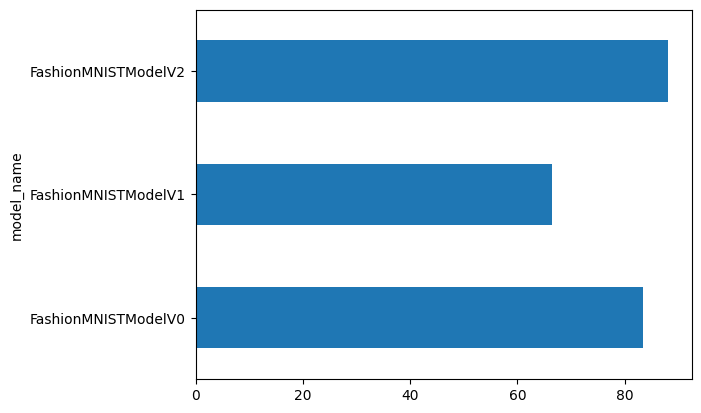

In [57]:
# little more visualization of the results
compare_results.set_index("model_name")["model_test_acc"].plot(kind="barh")
plt.xlabel=("accuracy")
plt.ylabel=("model")

In [58]:
# visualizating prediction making with the CNN
def make_predictions(model:torch.nn.Module,
                     data:list,
                     device: torch.device = device):
  prediction_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # add a batch size dim
      sample = torch.unsqueeze(sample, dim=0).to(device)
      model_logit = model(sample)
      pred_probability = torch.softmax(model_logit.squeeze(), dim=0)
      # matplotlib only works with the cpu
      prediction_probs.append(pred_probability.cpu())
      # return the prob list as a tensor
    return torch.stack(prediction_probs)



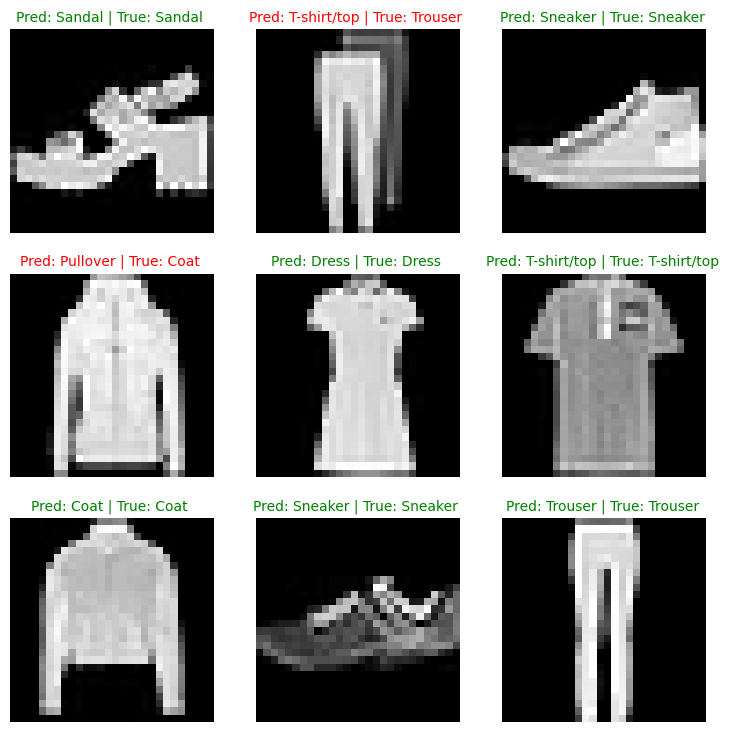

In [59]:
import random
random.seed(42)
test_samples = []
test_labels = []
# get 9 random samples
for sample,label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

pred_probs = make_predictions(cnnModel, test_samples)
# converting probs to labels
prediction_labels = pred_probs.argmax(dim=1)

plt.figure(figsize=(9,9))
nrows = 3
ncols = 3
for i,sample in enumerate(test_samples):
  # create a subplot
  plt.subplot(nrows, ncols, i+1)
  # # remove batch dim and plot target img
  plt.imshow(sample.squeeze(), cmap="gray")
  # get human readable text from labels
  pred_label = class_names[prediction_labels[i]]
  actual_label = class_names[test_labels[i]]
  # check equality between prediction and actual labels
  title_text = f'Pred: {pred_label} | True: {actual_label} '
  if pred_label == actual_label:
    plt.title(title_text, fontsize=10, c="g")
  else:
    plt.title(title_text, fontsize=10, c="r")
  plt.axis(False)

In [60]:
# more prediction evaluation with a confusion matrix
predictions = []
cnnModel.eval()
with torch.inference_mode():
  for img, label in dataLoader_Test:
    img, label = img.to(device), label.to(device)
    logit = cnnModel(img)
    pred = torch.softmax(logit.squeeze(), dim=0).argmax(dim=1)
    predictions.append(pred.cpu())
  pred_tensor = torch.cat(predictions)
pred_tensor


tensor([9, 2, 1,  ..., 8, 1, 8])

In [61]:
!pip install -q torchmetrics -U mlxtend
import torchmetrics, mlxtend



TypeError: 'str' object is not callable

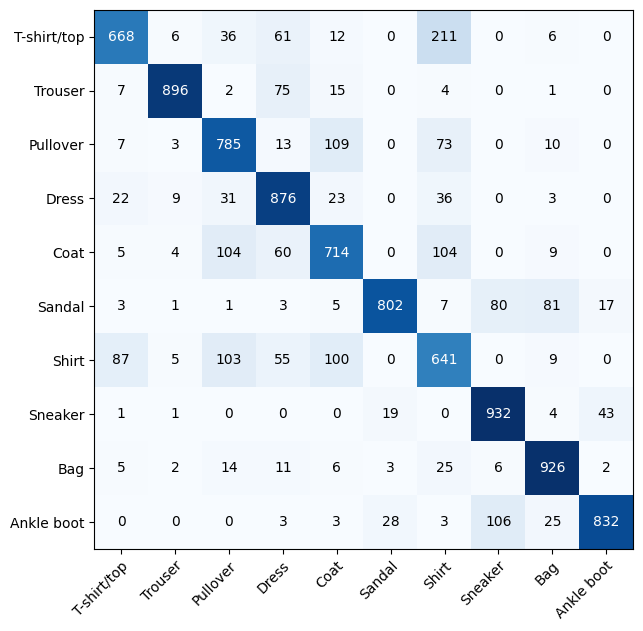

In [66]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# setup confusion matrix instance and compare predictions to target
confmat = ConfusionMatrix(task='multiclass',num_classes=len(class_names))
# labels = targets
confmat_tensor = confmat(preds=pred_tensor, target=test_data.targets)
figure, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10,7))


In [68]:
# saving and loading the model,practice on how this functionality works
from pathlib import Path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_NAME = "cnnModel.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(cnnModel.state_dict(), MODEL_SAVE_PATH) 

In [74]:
# loaded model has to have the same shape as the data you're loading from
loadedModel = FashionMNISTModelV2(1,10,len(class_names))
loadedModel.load_state_dict(torch.load(MODEL_SAVE_PATH))
loadedModel.to(device)

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifierLayer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [81]:
# evaluating the loaded model - should be same results as cnnModel
torch.manual_seed(42)
loadedModelResults = eval_model(
    model=loadedModel,
    data_loader=dataLoader_Test,
    loss_fn=cnnLoss,
    accuracy_fn=calculateAccuracy,
    device="cuda"
)

loadedModelResults,cnnModel_results

({'model_name': 'FashionMNISTModelV2',
  'model_test_loss': 0.32356318831443787,
  'model_test_acc': 88.06908945686901},
 {'model_name': 'FashionMNISTModelV2',
  'model_test_loss': 0.32356318831443787,
  'model_test_acc': 88.06908945686901})